In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split

# mandar a traer graficas
%matplotlib inline 
# para que este listo y podamos graficar
sns.set() 

In [2]:
test_df = pd.read_csv('titanic-test.csv')
train_df = pd.read_csv('titanic-train.csv')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_df[test_df.isna().any(axis=1) | test_df.isnull().any(axis=1)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
412,1304,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [4]:
test_df.notnull().apply(pd.Series.value_counts)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
False,NaN,NaN,NaN,NaN,86,NaN,NaN,NaN,1,327,NaN
True,418.0,418.0,418.0,418.0,332,418.0,418.0,418.0,417,91,418.0


In [5]:
test_df.isna().apply(pd.Series.value_counts)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
False,418.0,418.0,418.0,418.0,332,418.0,418.0,418.0,417,91,418.0
True,NaN,NaN,NaN,NaN,86,NaN,NaN,NaN,1,327,NaN


In [6]:
test_df.isnull().apply(pd.Series.value_counts)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
False,418.0,418.0,418.0,418.0,332,418.0,418.0,418.0,417,91,418.0
True,NaN,NaN,NaN,NaN,86,NaN,NaN,NaN,1,327,NaN


In [7]:
test_df[test_df['Fare'].isna()]['Fare'].value_counts()

Series([], Name: Fare, dtype: int64)

In [8]:
train_df[train_df.isna().any(axis=1) | train_df.isnull().any(axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [9]:
# informacion general de los datos
# Una ventaja de este data set es que no hay datos nulos
# una desventaja de arboles de decision es que no pueden haber datos
# nulos porque va a haber una prediccion mala
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


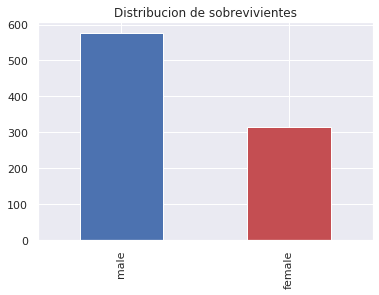

In [10]:
# Datos de sexo para saber distribucion de pasajetos
# ya cargado matplotlib por eso uso .plot 
train_df.Sex.value_counts().plot(kind = 'bar', color = ['b', 'r'])
plt.title('Distribucion de sobrevivientes')
plt.show()

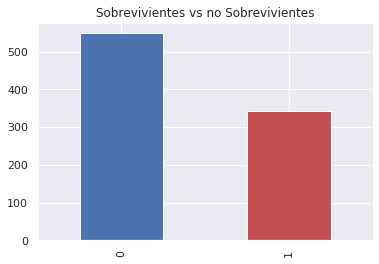

In [11]:
train_df.Survived.value_counts().plot(kind = 'bar', color = ['b', 'r'])
plt.title('Sobrevivientes vs no Sobrevivientes')
plt.show()

In [12]:
train_df.Ticket.value_counts()

CA. 2343      7
1601          7
347082        7
3101295       6
347088        6
             ..
PC 17603      1
A./5. 3235    1
330932        1
349234        1
349245        1
Name: Ticket, Length: 681, dtype: int64

In [13]:
train_df.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
E101           3
D              3
              ..
D48            1
E68            1
D19            1
C32            1
D49            1
Name: Cabin, Length: 147, dtype: int64

In [14]:
train_df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [0]:
# Hacemos preprocesado para convertir variables categoricas en cuantitativas
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

encoder_sex = label_encoder.fit_transform(train_df['Sex'])

In [0]:
# Vamos a llenar los datos nulos de Age con la media
# embarque ponemos S porque es el lugar donde mas se embarcaron
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
train_df['Embarked'] = train_df['Embarked'].fillna('S')

In [17]:
# Vamos a trabajar con los predictores
# cambios en los datos, eliminando atributos no utiles, axis = 1 columnas
train_predictors = train_df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis = 1)

# Tomamos columnas categoricas si cumple con ciertas condiciones
# un dato unico menor a 10
# que sea tipo de dato object
categorical_cols = [cname for cname in train_predictors.columns if
                        train_predictors[cname].nunique() < 10 and
                        train_predictors[cname].dtype == 'object'
                    ]
categorical_cols

['Sex', 'Embarked']

In [18]:
# variables numericas
numerical_cols = [cname for cname in train_predictors.columns if
                      train_predictors[cname].dtype in ['int64', 'float64']
                  ]
numerical_cols

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [19]:
my_cols = categorical_cols + numerical_cols

train_predictors = train_predictors[my_cols]
train_predictors

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
0,male,S,3,22.0,1,0,7.2500
1,female,C,1,38.0,1,0,71.2833
2,female,S,3,26.0,0,0,7.9250
3,female,S,1,35.0,1,0,53.1000
4,male,S,3,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,male,S,2,27.0,0,0,13.0000
887,female,S,1,19.0,0,0,30.0000
888,female,S,3,28.0,1,2,23.4500
889,male,C,1,26.0,0,0,30.0000


In [20]:
# dummy de informacion amplio para hacer una prediccion mas precisa
# get_dummies es un metodo para crear informacion dummy
# para crear informacion generada de una manera definida 
# anteriormente por las columnas y hacemos referencia al train_predictors
dummy_encoded_train_predictors = pd.get_dummies(train_predictors)
dummy_encoded_train_predictors

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,19.0,0,0,30.0000,1,0,0,0,1
888,3,28.0,1,2,23.4500,1,0,0,0,1
889,1,26.0,0,0,30.0000,0,1,1,0,0


In [21]:
# obtener las clases de entrenamiento que son primera, segunda y tercera clase
# de que forma esta dividida nuestra informacion
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [0]:
# dividimos nuestro dataset
y_target = train_df['Survived'].values
x_features_one = dummy_encoded_train_predictors.values

In [0]:
# random_state = 1 para tomar datos aleatorios
x_train, x_validation, y_train, y_validation = train_test_split(x_features_one, y_target, test_size = .25, random_state = 1)

In [0]:
# Entreno modelo con modelo de arbol de decision
tree_one = tree.DecisionTreeClassifier()
tree_one = tree_one.fit(x_features_one, y_target)

In [25]:
# round a 4 cifras
tree_one_accuracy = round(tree_one.score(x_features_one, y_target), 4)
print('Accuracy: %0.4f' % (tree_one_accuracy))

Accuracy: 0.9798


Hay un 97% de probabilidad de que se asigne la etiqueta correcta

In [26]:
tree_one.score(x_validation, y_validation)
# y_pred = tree_one.predict(x_validation)
# print(y_pred)
# print(y_validation)

0.9641255605381166

In [27]:
# generar una imagen del arbol de decision
from io import StringIO
from IPython.display import Image, display
#Permite generar cada uno de los caminos
import pydotplus

#permite generar archivo
out = StringIO()
#exportamos arbol
tree.export_graphviz(tree_one, out_file = out)

#metodos para crear arbol getvalue lo pasamos como parametro para que lo genere
graph = pydotplus.graph_from_dot_data(out.getvalue())
graph.write_png('titanic.png')

True

In [28]:
test_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [29]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [30]:
test_df.Embarked.value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64

In [0]:
# Vamos a llenar los datos nulos de Age con la media
# embarque ponemos S porque es el lugar donde mas se embarcaron
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())
test_df['Embarked'] = test_df['Embarked'].fillna('S')
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

In [32]:
# Vamos a trabajar con los predictores
# cambios en los datos, eliminando atributos no utiles, axis = 1 columnas
test_predictors = test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)

# Tomamos columnas categoricas si cumple con ciertas condiciones
# un dato unico menor a 10
# que sea tipo de dato object
test_categorical_cols = [cname for cname in test_predictors.columns if
                        test_predictors[cname].nunique() < 10 and
                        test_predictors[cname].dtype == 'object'
                    ]
test_categorical_cols

['Sex', 'Embarked']

In [33]:
# variables numericas
test_numerical_cols = [cname for cname in test_predictors.columns if
                      test_predictors[cname].dtype in ['int64', 'float64']
                  ]
test_numerical_cols

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [34]:
test_my_cols = test_categorical_cols + test_numerical_cols

test_predictors = test_predictors[test_my_cols]
test_predictors

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
0,male,Q,3,34.5,0,0,7.8292
1,female,S,3,47.0,1,0,7.0000
2,male,Q,2,62.0,0,0,9.6875
3,male,S,3,27.0,0,0,8.6625
4,female,S,3,22.0,1,1,12.2875
...,...,...,...,...,...,...,...
413,male,S,3,27.0,0,0,8.0500
414,female,C,1,39.0,0,0,108.9000
415,male,S,3,38.5,0,0,7.2500
416,male,S,3,27.0,0,0,8.0500


In [35]:
# dummy de informacion amplio para hacer una prediccion mas precisa
# get_dummies es un metodo para crear informacion dummy
# para crear informacion generada de una manera definida 
# anteriormente por las columnas y hacemos referencia al train_predictors
dummy_encoded_test_predictors = pd.get_dummies(test_predictors)
dummy_encoded_test_predictors

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0,1,0,1,0
1,3,47.0,1,0,7.0000,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,1,0,0,1
4,3,22.0,1,1,12.2875,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
413,3,27.0,0,0,8.0500,0,1,0,0,1
414,1,39.0,0,0,108.9000,1,0,1,0,0
415,3,38.5,0,0,7.2500,0,1,0,0,1
416,3,27.0,0,0,8.0500,0,1,0,0,1


In [36]:
# aplicacion del modelo al dataset
# dummy_encoded_test_predictors['Fare'].max()
x_features_one_test = dummy_encoded_test_predictors.values
y_pred = tree_one.predict(x_features_one_test)
y_pred
# np.any(np.isnan(x_features_one_test))
# np.all(np.isfinite(x_features_one_test))

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,